In [1]:
import sys

import numpy as np
import torch.nn as nn

sys.path.append(".")
import random

import utils
from models.ResNet1D.ResNet1D import ResNet1D
from scipy.signal import resample_poly
import matplotlib.pyplot as plt
import torch


Parameters

In [2]:
samp_rate = 1000

Loads signal

In [3]:
fpath = "data/th-1/data/Mouse12-120806/Mouse12-120806.eeg"
LFPs_1250Hz, prop_dict = utils.pj.load.th_1(
    lpath_eeg=fpath, start_sec_cut=0, dur_sec_cut=-1
)


Downsamples the signal from 1250 to 1000 Hz
# 1,250 -> *4 upsampling -> 5,000 -> /5 downsampling -> 1,000 Hz

In [4]:
LFPs = resample_poly(LFPs_1250Hz, 4, 5, axis=1).astype(np.float32)

Use only a part of signal for the computational reason

In [5]:
lfp_all = LFPs[0][:, np.newaxis]
lfp_start_sec = 0
lfp_end_sec = 300  # 5 min
lfp_step_sec = float(1 / samp_rate)
lfp_time_x = np.arange(lfp_start_sec, lfp_end_sec, lfp_step_sec).round(3)
lfp = lfp_all[lfp_start_sec * samp_rate : lfp_end_sec * samp_rate]


Detects Ripple Candidates

In [6]:
lfp_h = len(lfp) / samp_rate / 60 / 60
print(f"\nDetecting ripples from {fpath} (Length: {lfp_h:.1f}h)\n".format())

lo_hz_ripple = utils.general.load("./conf/global.yaml")["RIPPLE_CANDI_LIM_HZ"][0]
hi_hz_ripple = utils.general.load("./conf/global.yaml")["RIPPLE_CANDI_LIM_HZ"][1]
_, _, rip_sec = utils.pj.define_ripple_candidates(
    lfp_time_x,
    lfp,
    samp_rate,
    lo_hz=lo_hz_ripple,
    hi_hz=hi_hz_ripple,
    zscore_threshold=1,
)
rip_sec = rip_sec.reset_index()



Detecting ripples from data/th-1/data/Mouse12-120806/Mouse12-120806.eeg (Length: 0.1h)


Ripple Band 150-250 Hz



Checks whether each ripple can be separated in 400-ms segment

In [7]:
def check_if_a_ripple_candidate_is_separable(rip_sec, i_rip, window_size_pts=400):
    window_size_sec = window_size_pts / samp_rate

    ## Condition 1
    rip_i = rip_sec.iloc[i_rip]
    is_rip_i_short = (rip_i["end_sec"] - rip_i["start_sec"]) < window_size_sec

    ## Condition 2
    if i_rip != 0:
        rip_i_minus_1 = rip_sec.iloc[i_rip - 1]
        before_end_sec = rip_i_minus_1["end_sec"]
    else:
        before_end_sec = 0

    if i_rip != len(rip_sec) - 1:
        rip_i_plus_1 = rip_sec.iloc[i_rip + 1]
        next_start_sec = rip_i_plus_1["start_sec"]
    else:
        next_start_sec = before_end_sec + window_size_sec

    is_inter_ripple_interval_long = window_size_sec < (next_start_sec - before_end_sec)
    is_rip_i_separable = is_rip_i_short & is_inter_ripple_interval_long
    return is_rip_i_separable


In [8]:
def separate_a_ripple_candidate(lfp, rip_sec, i_rip, window_size_pts=400):
    samp_rate = 1000
    # window_size_sec = window_size_pts / samp_rate
    rip = rip_sec.iloc[i_rip].copy()
    dur_sec = rip["end_sec"] - rip["start_sec"]
    dur_pts = int(dur_sec * samp_rate)
    dof = window_size_pts - dur_pts
    cut_start_pts = int(rip["start_sec"] * samp_rate) - random.randint(0, dof)
    lfp_cut = lfp[cut_start_pts : cut_start_pts + window_size_pts]
    return lfp_cut


In [9]:
rip_sec["duration_sec"] = rip_sec["end_sec"] - rip_sec["start_sec"]
# (rip_sec["duration_sec"] * 1000).hist(bins=100)
# plt.show()

rip_sec["is_separable"] = [
    check_if_a_ripple_candidate_is_separable(rip_sec, i_rip)
    for i_rip in range(len(rip_sec))
]

rip_sec["cut_LFP"] = np.nan
rip_sec["cut_LFP"] = rip_sec["cut_LFP"].astype(object)
for i_rip in range(len(rip_sec)):
    if rip_sec.iloc[i_rip]["is_separable"]:
        rip_sec.loc[i_rip, "cut_LFP"] = separate_a_ripple_candidate(lfp, rip_sec, i_rip)


Loads the trained model

In [10]:
MODEL_CONF = utils.general.load("./models/ResNet1D/ResNet1D.yaml")
model = ResNet1D(MODEL_CONF)
model = model.to("cuda")
model.eval()
checkpoints = utils.general.load(
    "./ripples/detect_ripples/CNN/train_FvsT/checkpoints/mouse_test#01_epoch#000.pth"
)
model.load_state_dict(
    utils.general.cvt_multi2single_model_state_dict(checkpoints["model_state_dict"])
)


<All keys matched successfully>

Estimates the ripple probabilities

In [11]:
softmax = nn.Softmax(dim=-1)
batch_size = 128
labels = {0: "F", 1: "T"}
utils.plt.configure_mpl(plt, dpi=100, figscale=1, fontsize=8, legendfontsize=7)


rip_sec["pred_proba_for_ripple"] = np.nan  # initialization
n_batches = len(rip_sec) // batch_size + 1
for i_batch in range(n_batches):
    ## Samples
    start_idx = i_batch * batch_size
    end_idx = (i_batch + 1) * batch_size
    _Xb = rip_sec["cut_LFP"].iloc[start_idx:end_idx]
    indi = _Xb.index[~_Xb.isna()]  # _indi[~_Xb.isna()]
    Xb = rip_sec["cut_LFP"].iloc[indi]

    ## NN Outputs
    Xb = torch.tensor(np.vstack(Xb).astype(np.float32)).cuda()
    logits = model(Xb)
    pred_proba = softmax(logits)
    # pred_class = pred_proba.argmax(dim=-1)  # 0: T, 1: F

    rip_sec.loc[indi, "pred_proba_for_ripple"] = (
        pred_proba[:, 1].detach().cpu().numpy().copy()
    )



Matplotilb has been configured as follows:
{'figure.dpi': 100, 'savefig.dpi': 300, 'figure.figsize': '(16.2, 10) [cm]', 'font.size': 8, 'axes.labelsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.titlesize': 8, 'legend.fontsize': 7, 'pdf.fonttype': 42, 'ps.fonttype': 42, 'axes.spines.top': True, 'axes.spines.right': True}.



Plots


Matplotilb has been configured as follows:
{'figure.dpi': 100, 'savefig.dpi': 300, 'figure.figsize': '(18.1, 10.0) [cm]', 'font.size': 8, 'axes.labelsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.titlesize': 8, 'legend.fontsize': 7, 'pdf.fonttype': 42, 'ps.fonttype': 42, 'axes.spines.top': False, 'axes.spines.right': False, 'xtick.major.size': 2.032, 'ytick.major.size': 2.032, 'xtick.major.width': 0.508, 'ytick.major.width': 0.508}.



/usr/local/lib64/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_85364/2503076861.py:58: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


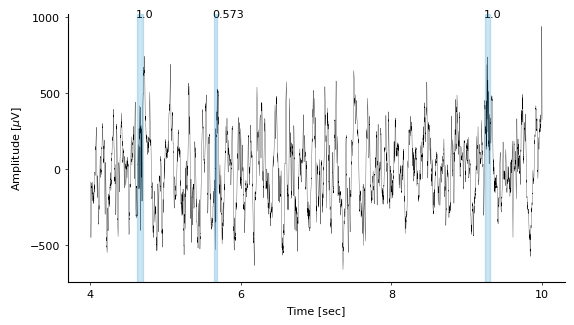

In [12]:
utils.plt.configure_mpl(
    plt,
    figsize=(18.1, 10),
    fontsize=8,
    labelsize=8,
    legendfontsize=7,
    tick_size=0.8,
    tick_width=0.2,
    hide_spines=True,
)

fig, ax = plt.subplots()
start_plt_sec = 4
dur_plt_sec = 6
end_plt_sec = start_plt_sec + dur_plt_sec
start_plt_pts = start_plt_sec * samp_rate
end_plt_pts = end_plt_sec * samp_rate

lfp_plt = lfp[start_plt_pts:end_plt_pts]

x_pts = np.arange(len(lfp))
x_sec = x_pts / samp_rate
x_plt_sec = x_sec[start_plt_pts:end_plt_pts]

rip_sec_plt = rip_sec[
    (start_plt_sec <= rip_sec["end_sec"]) & (rip_sec["start_sec"] <= end_plt_sec)
]
rip_sec_plt["end_sec"].iloc[-1] = np.clip(
    rip_sec_plt["end_sec"].iloc[-1], 0, end_plt_sec
)


## Original
ax.plot(x_plt_sec, lfp_plt, label="LFP", linewidth=0.2, color="black")

## Ripple
for i_rip in range(len(rip_sec_plt)):
    row = rip_sec_plt.iloc[i_rip]
    rip_sec_med = (row["start_sec"] + row["end_sec"]) / 2
    ax.text(rip_sec_med - 0.05, 1000, str(round(row["pred_proba_for_ripple"], 3)))

    color_str = "gray" if np.isnan(row["pred_proba_for_ripple"]) else "blue"
    color = utils.plt.colors.to_RGBA(
        color_str,
        alpha=0.2,
    )

    ax.axvspan(
        row.start_sec,
        row.end_sec - 1.0 / samp_rate,
        color=color,
        zorder=1000,
    )

ax = utils.plt.ax_set_n_ticks(ax)
ax.set_ylabel(f"Amplitude [$\mu$V]")
ax.set_xlabel("Time [sec]")
fig.show()
